# CICY4: LSTM-based network (LSTM-424)

In [1]:
import numpy as np
import random
import pandas as pd
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
#sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

 # LSTM-based network architecture

In [4]:
class LSTM_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(LSTM_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.lstm = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)

        self.feat_vec_size = self.M
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        #output is NxTxM
        out, _ = self.lstm(X, (h0,c0))
        #we only want the output y at the final time step
        # output is now of shape (N, M)
        xx = out[:, -1, :]
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)
        return xx

In [5]:
model = LSTM_block(20, 424, 2, 4)
model.to(device)

LSTM_block(
  (lstm): LSTM(20, 424, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=424, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
)

In [6]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(f'Total numbers of parameters: {sum(params)}')

Total numbers of parameters: 2637316


# Load data & define dataset class

In [7]:
# load data
path = '/kaggle/input/cicy4-data-processing/'
X_train = np.load(path + 'conf_Xtrain.npy')
X_test = np.load(path+'conf_Xtest.npy')
X_valid = np.load(path+'conf_Xvalid.npy')

y_train = np.load(path+'hodge_ytrain.npy')
y_test= np.load(path+'hodge_ytest.npy')
y_valid = np.load(path+'hodge_yvalid.npy')

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(652092, 16, 20) (72455, 16, 20) (181137, 16, 20)
(652092, 4) (72455, 4) (181137, 4)


In [8]:
#Convert data to torch tensor with float32 precision
#(needed to be compatible with the floating decision of the network parameters)
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

X_valid = torch.from_numpy(X_valid.astype(np.float32))
y_valid = torch.from_numpy(y_valid.astype(np.float32))

X_test = torch.from_numpy(X_test.astype(np.float32))
y_test= torch.from_numpy(y_test.astype(np.float32))

In [9]:
class CICY4Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X0 = self.X[idx]
        y0 = self.y[idx]
        return X0, y0

train_set = CICY4Dataset(X_train, y_train)
val_set = CICY4Dataset(X_valid, y_valid)
test_set = CICY4Dataset(X_test, y_test)

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# Utility functions

In [11]:
def train_one_epoch(model, criterion, optimizer, train_loader):
    model.train()
    train_loss = []
    for inputs, target in train_loader:
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    #average the train_loss list in for all batches in the train_gen
    train_loss = np.mean(train_loss)
    return train_loss

In [12]:
def validate_one_epoch(model, criterion, optimizer, val_loader):
    model.eval()
    test_loss = []
    for inputs, target in val_loader:
        inputs, target = inputs.to(device), target.to(device)
        out = model(inputs)
        loss = criterion(out, target)
        test_loss.append(loss.item())
    #average the test_loss list in for all batches in the test_gen
    test_loss = np.mean(test_loss)
    return test_loss

In [13]:
def batch_gd_scheduler(model, new_model_name, criterion, optimizer, train_loader, val_loader, scheduler,
                         epochs, device, batch_size=128):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    patience = 0
    best_loss = 1000
    max_patience = 20
    for i in range(epochs):
        t0 = datetime.now()
        train_loss = train_one_epoch(model, criterion, optimizer,train_loader)
        test_loss = validate_one_epoch(model, criterion, optimizer,val_loader)
        #Early stopping based on test loss
        if i == 0:
            best_loss = test_loss
            torch.save(model, f'/kaggle/working/{new_model_name}.pt')
            #torch.save(model, path+f'{new_model_name}.pt')
            print(f'Model saved as {new_model_name} at epoch {i}')
        else:
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model, f'/kaggle/working/{new_model_name}.pt')
                #torch.save(model, path+f'{new_model_name}.pt')
                print(f'Model overwritten at epoch {i}, new best val loss {best_loss}')
                patience = 0
            else:
                patience = patience +1
                #print(f'No improvement, current patience level is {patience} at epoch {i}')
        if patience > max_patience:
            print(f'Max patience reached, training is terminated at epoch {i}')
            break
        #Apply scheduler after the train+validate parts
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(test_loss)
        after_lr = optimizer.param_groups[0]["lr"]
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        #write the losses into a csv file
        loss_dict = {'train_loss': train_losses, 'test_loss': test_losses}
        dd = pd.DataFrame(loss_dict)
        dd.to_csv('loss_dict_lstm_424.csv', index = False)
        dt = datetime.now()-t0
        if i%10==0:
            print(f'Epoch: {i+1}/{epochs}, train loss: {train_loss: .3f}, val_loss: {test_loss: .3f}, duration: {dt}, learning rate: {before_lr, after_lr}')
    return train_losses, test_losses


In [14]:
def train_from_scratch_or_load(load_model_weight,new_model_name, epochs):
    if load_model_weight==None:
        #criterion = nn.MSELoss()
        criterion = nn.HuberLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, min_lr = 1e-8)
        train_losses, test_losses=batch_gd_scheduler(model, new_model_name, criterion,
                                                     optimizer,train_loader, val_loader,
                                                      scheduler, epochs,
                                                       device = device)
        return train_losses, test_losses
    else:
        if torch.cuda.is_available():
            trained_model = torch.load(load_model_weight)
        else:
            trained_model = torch.load(load_model_weight, map_location=torch.device('cpu'))
        return trained_model

In [15]:
def load_and_retrain(load_model_weight, new_model_name, epochs):
    trained_model = torch.load(load_model_weight)
    criterion = nn.HuberLoss()
    optimizer = torch.optim.AdamW(trained_model.parameters(),lr=0.0001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, min_lr = 5e-7)
    trained_model.train()
    train_losses, test_losses=batch_gd_scheduler(trained_model,new_model_name, criterion, optimizer,
                                                 train_loader, val_loader,
                                                 scheduler, epochs,
                                                 device = device)
    return trained_model, train_losses, test_losses

In [16]:
def plot_losses(train_losses, test_losses):
    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='val loss')
    plt.legend()
    plt.show()

In [17]:
################## GET PREDICTIONS + ACCURACY #####################
def get_pred_n_acc(models, device, dataloader, num_iter):
    i = 0
    ypreds =[]
    targets = []
    #The last batch might not have size 128
    while i< num_iter:
        for data, target in dataloader:
            #this empty list is to hold all models' preds
            ypred = []
            data= data.to(device)
            data = data.to(torch.float32)
            target = target.to(torch.float32)
            #append the 'i^th' target
            targets.append(target)
            for model in models:
                model.eval()
                yp = model(data)
                yp = yp.detach().cpu().numpy()
                ypred.append(yp)
            #take the mean of all models' predictions
            ypred = np.array(ypred).mean(axis = 0)
            ypred = np.round(ypred)
            i+=1
            #append ypred, targets inside the 'i' loop
            # append the 'i^th' mean prediction
            ypreds.append(ypred)
            if i == num_iter:
                break
     #Do not convert ypreds, targets to np.array at this point,
    #since the last batch has a different size, causing an error !
    #CALCULATING ACCURACY
    yp =  np.concatenate([ypreds[j] for j in range(len(ypreds))], axis = 0)
    tgs =  np.concatenate([targets[j] for j in range(len(targets))], axis = 0)
    h11_acc = ((yp[:,0] == tgs[:,0]).sum())/len(yp)
    h21_acc = ((yp[:,1] == tgs[:,1]).sum())/len(yp)
    h31_acc = ((yp[:,2] == tgs[:,2]).sum())/len(yp)
    h22_acc = ((yp[:,3] == tgs[:,3]).sum())/len(yp)
    acc = [h11_acc*100,h21_acc*100,h31_acc*100,h22_acc*100 ]
    return  yp, tgs, acc


# Train loop

In [18]:
load_model_weight = None
epochs = 550
new_model_name = 'LSTM-424'
if load_model_weight is None:
    train_losses, test_losses=train_from_scratch_or_load(load_model_weight,new_model_name,  epochs)
else:
    trained_model_v00 = train_from_scratch_or_load(load_model_weight, new_model_name, epochs)
    #Train accuracy
    yt, tgt, acct = get_pred_n_acc([trained_model_v00], device, train_loader, num_iter = len(train_loader))
    #validation accuracy
    yv, tgv, accv = get_pred_n_acc([trained_model_v00], device, val_loader, num_iter = len(val_loader))
    print(f'Train data, target shapes: {yt.shape, tgt.shape},\n train accuracies {acct}')
    print(f'Validation data, target shapes: {yv.shape, tgv.shape},\n validation accuracies {accv}')
    #Test accuracy
    yts, tgts, accts = get_pred_n_acc([trained_model_v00], device, test_loader, num_iter = len(test_loader))
    print(f'Test data, target shapes: {yts.shape, tgts.shape},\n test accuracies {accts}')

Model saved as LSTM-424 at epoch 0
Epoch: 1/550, train loss:  9.997, val_loss:  9.831, duration: 0:00:51.184695, learning rate: (0.01, 0.01)
Model overwritten at epoch 1, new best val loss 8.560033743553902
Model overwritten at epoch 4, new best val loss 8.481373691054248
Model overwritten at epoch 8, new best val loss 8.417339119751407
Model overwritten at epoch 10, new best val loss 8.414050863323178
Epoch: 11/550, train loss:  8.443, val_loss:  8.414, duration: 0:00:50.775821, learning rate: (0.01, 0.01)
Model overwritten at epoch 11, new best val loss 8.379450290081152
Model overwritten at epoch 19, new best val loss 8.324216715662988
Epoch: 21/550, train loss:  8.457, val_loss:  8.387, duration: 0:00:50.909989, learning rate: (0.01, 0.01)
Epoch: 31/550, train loss:  8.561, val_loss:  8.769, duration: 0:00:50.713366, learning rate: (0.01, 0.001)
Model overwritten at epoch 32, new best val loss 7.3556589096311535
Model overwritten at epoch 33, new best val loss 7.299337129744273
Mod

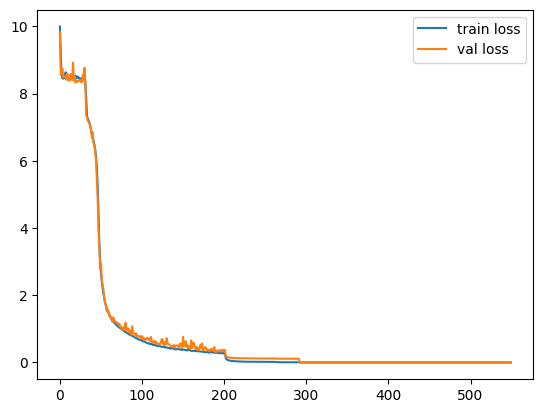

In [19]:
plot_losses(train_losses, test_losses)

# Accuracies

In [20]:
#Train accuracy
yt, tgt, acct = get_pred_n_acc([model], device, train_loader, num_iter = len(train_loader))
#validation accuracy
yv, tgv, accv = get_pred_n_acc([model], device, val_loader, num_iter = len(val_loader))
print(f'Train data, target shapes: {yt.shape, tgt.shape},\n train accuracies {acct}')
print(f'Validation data, target shapes: {yv.shape, tgv.shape},\n validation accuracies {accv}')


Train data, target shapes: ((652092, 4), (652092, 4)),
 train accuracies [99.98727173466321, 99.76460376756654, 99.93666537850487, 99.58947510473982]
Validation data, target shapes: ((72455, 4), (72455, 4)),
 validation accuracies [99.5845697329377, 97.05748395555862, 93.20543785798081, 74.90580360223586]


In [21]:
#Test accuracy
yts, tgts, accts = get_pred_n_acc([model], device, test_loader, num_iter = len(test_loader))
print(f'Test data, target shapes: {yts.shape, tgts.shape},\n test accuracies {accts}')


Test data, target shapes: ((181137, 4), (181137, 4)),
 test accuracies [99.56552222903106, 97.06078824315297, 93.17974792560328, 74.65399117794819]
